In [1]:
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import tarfile
from nltk import FreqDist
from functools import reduce

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Permute, dot, add, concatenate
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Activation
import matplotlib.pyplot as plt

In [2]:
base_path = '/content/drive/MyDrive/DL_Study/AIFFEL/GoingDeeper/GD_14_InferencingAI/e-28-korean/'
test_data_path = base_path + 'qa1_single-supporting-fact_test_kor.txt'
train_data_path = base_path + 'qa1_single-supporting-fact_train_kor.txt'

In [3]:
def read_data(dir):
    stories, questions, answers = [], [], [] # 각각 스토리, 질문, 답변을 저장할 예정
    story_temp = [] # 현재 시점의 스토리 임시 저장
    lines = open(dir, "rb")

    for line in lines:
        line = line.decode("utf-8") # b' 제거
        line = line.strip() # '\n' 제거
        idx, text = line.split(" ", 1) # 맨 앞에 있는 id number 분리
        # 여기까지는 모든 줄에 적용되는 전처리

        if int(idx) == 1:
            story_temp = []
        
        if "\t" in text: # 현재 읽는 줄이 질문 (tab) 답변 (tab)인 경우
            question, answer, _ = text.split("\t") # 질문과 답변을 각각 저장
            stories.append([x for x in story_temp if x]) # 지금까지의 누적 스토리를 스토리에 저장
            questions.append(question)
            answers.append(answer)

        else: # 현재 읽는 줄이 스토리인 경우
            story_temp.append(text) # 임시 저장

    lines.close()
    return stories, questions, answers

In [4]:
train_data = read_data(train_data_path)
test_data = read_data(test_data_path)

In [5]:
train_stories, train_questions, train_answers = read_data(train_data_path)
test_stories, test_questions, test_answers = read_data(test_data_path)

In [6]:
print("train 스토리 개수:", len(train_stories))
print("train 질문 개수:", len(train_questions))
print("train 답변 개수:", len(train_answers))
print("test 스토리 개수:", len(test_stories))
print("test 질문 개수:", len(test_questions))
print("test 답변 개수:", len(test_answers))

train 스토리 개수: 10000
train 질문 개수: 10000
train 답변 개수: 10000
test 스토리 개수: 1000
test 질문 개수: 1000
test 답변 개수: 1000


In [7]:
!pip install konlpy
!pip install customized_konlpy

     |████████████████████████████████| 19.4MB 1.2MB/s 
     |████████████████████████████████| 460kB 55.6MB/s 
     |████████████████████████████████| 92kB 13.6MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
     |████████████████████████████████| 890kB 3.9MB/s 


In [8]:
train_stories[:100]

[['필웅이는 화장실로 갔습니다.', '은경이는 복도로 이동했습니다.'],
 ['필웅이는 화장실로 갔습니다.',
  '은경이는 복도로 이동했습니다.',
  '수종이는 복도로 복귀했습니다.',
  '경임이는 정원으로 갔습니다.'],
 ['필웅이는 화장실로 갔습니다.',
  '은경이는 복도로 이동했습니다.',
  '수종이는 복도로 복귀했습니다.',
  '경임이는 정원으로 갔습니다.',
  '은경이는 사무실로 갔습니다.',
  '경임이는 화장실로 뛰어갔습니다.'],
 ['필웅이는 화장실로 갔습니다.',
  '은경이는 복도로 이동했습니다.',
  '수종이는 복도로 복귀했습니다.',
  '경임이는 정원으로 갔습니다.',
  '은경이는 사무실로 갔습니다.',
  '경임이는 화장실로 뛰어갔습니다.',
  '필웅이는 복도로 갔습니다.',
  '수종이는 사무실로 가버렸습니다.'],
 ['필웅이는 화장실로 갔습니다.',
  '은경이는 복도로 이동했습니다.',
  '수종이는 복도로 복귀했습니다.',
  '경임이는 정원으로 갔습니다.',
  '은경이는 사무실로 갔습니다.',
  '경임이는 화장실로 뛰어갔습니다.',
  '필웅이는 복도로 갔습니다.',
  '수종이는 사무실로 가버렸습니다.',
  '은경이는 정원으로 복귀했습니다.',
  '은경이는 침실로 갔습니다.'],
 ['경임이는 사무실로 가버렸습니다.', '경임이는 화장실로 이동했습니다.'],
 ['경임이는 사무실로 가버렸습니다.',
  '경임이는 화장실로 이동했습니다.',
  '필웅이는 침실로 이동했습니다.',
  '수종이는 복도로 갔습니다.'],
 ['경임이는 사무실로 가버렸습니다.',
  '경임이는 화장실로 이동했습니다.',
  '필웅이는 침실로 이동했습니다.',
  '수종이는 복도로 갔습니다.',
  '은경이는 정원으로 이동했습니다.',
  '은경이는 사무실로 가버렸습니다.'],
 ['경임이는 사무실로 가버렸습니다.',
  '경임이는 화장실로 이동했습니다.',
  '필웅이는 침실로 이동했습니다.',
  '수종이는 복도로 

In [9]:
from ckonlpy.tag import Twitter
twitter = Twitter()
name_list = ['은경이', '필웅이', '수종이', '경임이']
for name in name_list:
  twitter.add_dictionary(name, 'Noun')

twitter.morphs('은경이는 사무실로 갔습니다.')

/usr/local/lib/python3.7/dist-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


['은경이', '는', '사무실', '로', '갔습니다', '.']

In [10]:
from functools import reduce
def tokenize(sent):
  stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다', '.']
  result=[word for word in twitter.morphs(sent) if word not in stopwords]

  return result

def preprocess_data(train_data, test_data):
    counter = FreqDist()
    
    # 두 문장의 story를 하나의 문장으로 통합하는 함수
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    # 각 샘플의 길이를 저장하는 리스트
    story_len = []
    question_len = []
    
    for stories, questions, answers in [train_data, test_data]:
        for story in stories:
            stories = tokenize(flatten(story)) # 스토리의 문장들을 펼친 후 토큰화
            story_len.append(len(stories)) # 각 story의 길이 저장
            for word in stories: # 단어 집합에 단어 추가
                counter[word] += 1
        for question in questions:
            question = tokenize(question)
            question_len.append(len(question))
            for word in question:
                counter[word] += 1
        for answer in answers:
            answer = tokenize(answer)
            for word in answer:
                counter[word] += 1

    # 단어장 생성
    word2idx = {word : (idx + 1) for idx, (word, _) in enumerate(counter.most_common())}
    idx2word = {idx : word for word, idx in word2idx.items()}

    # 가장 긴 샘플의 길이
    story_max_len = np.max(story_len)
    question_max_len = np.max(question_len)

    return word2idx, idx2word, story_max_len, question_max_len

In [11]:
word2idx, idx2word, story_max_len, question_max_len = preprocess_data(train_data, test_data)

def vectorize(data, word2idx, story_maxlen, question_maxlen):
    Xs, Xq, Y = [], [], []
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    stories, questions, answers = data
    for story, question, answer in zip(stories, questions, answers):
        xs = [word2idx[w] for w in tokenize(flatten(story))]
        xq = [word2idx[w] for w in tokenize(question)]
        Xs.append(xs)
        Xq.append(xq)
        Y.append(word2idx[answer])

    # 스토리와 질문은 각각의 최대 길이로 패딩
    # 정답은 원-핫 인코딩
    return pad_sequences(Xs, maxlen=story_maxlen),\
           pad_sequences(Xq, maxlen=question_maxlen),\
           to_categorical(Y, num_classes=len(word2idx) + 1)

In [12]:
Xstrain, Xqtrain, Ytrain = vectorize(train_data, word2idx, story_max_len, question_max_len)
Xstest, Xqtest, Ytest = vectorize(test_data, word2idx, story_max_len, question_max_len)

print(word2idx)
vocab_size = len(word2idx) + 1
# 에포크 횟수
train_epochs = 120
# 배치 크기
batch_size = 32
# 임베딩 크기
embed_size = 50
# LSTM의 크기
lstm_size = 64
# 과적합 방지 기법인 드롭아웃 적용 비율
dropout_rate = 0.30

input_sequence = Input((story_max_len,))
question = Input((question_max_len,))
 
print('Stories :', input_sequence)
print('Question:', question)

{'로': 1, '했습니다': 2, '경임이': 3, '은경이': 4, '수종이': 5, '필웅이': 6, '이동': 7, '가버렸습니다': 8, '뛰어갔습니다': 9, '복귀': 10, '화장실': 11, '정원': 12, '복도': 13, '갔습니다': 14, '사무실': 15, '부엌': 16, '침실': 17, '어디': 18, '야': 19, '?': 20}
Stories : KerasTensor(type_spec=TensorSpec(shape=(None, 47), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Question: KerasTensor(type_spec=TensorSpec(shape=(None, 4), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


In [13]:
# 스토리를 위한 첫 번째 임베딩. 그림에서의 Embedding A
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=embed_size))
input_encoder_m.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, embed_size) / 샘플의 수, 문장의 최대 길이, 임베딩 벡터의 차원
 
# 스토리를 위한 두 번째 임베딩. 그림에서의 Embedding C
# 임베딩 벡터의 차원을 question_max_len(질문의 최대 길이)로 한다.
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=question_max_len))
input_encoder_c.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이(임베딩 벡터의 차원)


# 질문을 위한 임베딩. 그림에서의 Embedding B
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=embed_size,
                               input_length=question_max_len))
question_encoder.add(Dropout(dropout_rate))
# 결과 : (samples, question_max_len, embed_size) / 샘플의 수, 질문의 최대 길이, 임베딩 벡터의 차원
# 실질적인 임베딩 과정
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

print('Input encoded m', input_encoded_m, '\n')
print('Input encoded c', input_encoded_c, '\n')
print('Question encoded', question_encoded, '\n')

# 스토리 단어들과 질문 단어들 간의 유사도를 구하는 과정
# 유사도는 내적을 사용한다.
match = dot([input_encoded_m, question_encoded], axes=-1, normalize=False)
match = Activation('softmax')(match)
print('Match shape', match)
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이

# 매칭 유사도 행렬과 질문에 대한 임베딩을 더한다.
response = add([match, input_encoded_c])  # (samples, story_maxlen, question_max_len)
response = Permute((2, 1))(response)  # (samples, question_max_len, story_maxlen)
print('Response shape', response)

# concatenate the response vector with the question vector sequence
answer = concatenate([response, question_encoded])
print('Answer shape', answer)
 
answer = LSTM(lstm_size)(answer)  # Generate tensors of shape 32
answer = Dropout(dropout_rate)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

Input encoded m KerasTensor(type_spec=TensorSpec(shape=(None, 47, 50), dtype=tf.float32, name=None), name='sequential/dropout/Identity:0', description="created by layer 'sequential'") 

Input encoded c KerasTensor(type_spec=TensorSpec(shape=(None, 47, 4), dtype=tf.float32, name=None), name='sequential_1/dropout_1/Identity:0', description="created by layer 'sequential_1'") 

Question encoded KerasTensor(type_spec=TensorSpec(shape=(None, 4, 50), dtype=tf.float32, name=None), name='sequential_2/dropout_2/Identity:0', description="created by layer 'sequential_2'") 

Match shape KerasTensor(type_spec=TensorSpec(shape=(None, 47, 4), dtype=tf.float32, name=None), name='activation/truediv:0', description="created by layer 'activation'")
Response shape KerasTensor(type_spec=TensorSpec(shape=(None, 4, 47), dtype=tf.float32, name=None), name='permute/transpose:0', description="created by layer 'permute'")
Answer shape KerasTensor(type_spec=TensorSpec(shape=(None, 4, 97), dtype=tf.float32, name=No

In [14]:
import os

# 모델 컴파일
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['acc'])
 
# 테스트 데이터를 검증 데이터로 사용하면서 모델 훈련 시작
history = model.fit([Xstrain, Xqtrain],
         Ytrain, batch_size, train_epochs,
         validation_data=([Xstest, Xqtest], Ytest))
 
# 훈련 후에는 모델 저장
model_path = base_path+'model.h5'
model.save(model_path)

Epoch 1/120
313/313 [==============================] - 20s 9ms/step - loss: 2.0099 - acc: 0.1569 - val_loss: 1.8005 - val_acc: 0.1570
Epoch 2/120
313/313 [==============================] - 2s 5ms/step - loss: 1.7722 - acc: 0.2044 - val_loss: 1.6474 - val_acc: 0.3270
Epoch 3/120
313/313 [==============================] - 2s 5ms/step - loss: 1.6339 - acc: 0.3057 - val_loss: 1.5282 - val_acc: 0.3870
Epoch 4/120
313/313 [==============================] - 2s 5ms/step - loss: 1.5424 - acc: 0.3648 - val_loss: 1.4948 - val_acc: 0.4160
Epoch 5/120
313/313 [==============================] - 2s 5ms/step - loss: 1.4928 - acc: 0.4078 - val_loss: 1.4463 - val_acc: 0.4640
Epoch 6/120
313/313 [==============================] - 2s 5ms/step - loss: 1.4413 - acc: 0.4470 - val_loss: 1.3694 - val_acc: 0.4860
Epoch 7/120
313/313 [==============================] - 2s 5ms/step - loss: 1.3722 - acc: 0.4823 - val_loss: 1.3335 - val_acc: 0.4930
Epoch 8/120
313/313 [==============================] - 2s 5ms/step -

In [14]:
print("\n 테스트 정확도: %.4f" % (model.evaluate([Xstest, Xqtest], Ytest)[1]))

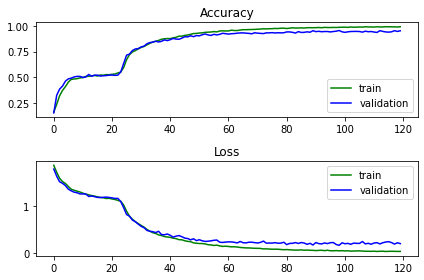

In [15]:
# plot accuracy and loss plot
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

# labels
ytest = np.argmax(Ytest, axis=1)

# get predictions
Ytest_ = model.predict([Xstest, Xqtest])
ytest_ = np.argmax(Ytest_, axis=1)

In [16]:
NUM_DISPLAY = 30

print("{:20}|{:7}|{}".format("질문", "실제값", "예측값"))
print(39 * "-")

for i in range(NUM_DISPLAY):
    question = " ".join([idx2word[x] for x in Xqtest[i].tolist()])
    label = idx2word[ytest[i]]
    prediction = idx2word[ytest_[i]]
    print("{:20}: {:8} {}".format(question, label, prediction))

질문                  |실제값    |예측값
---------------------------------------
은경이 어디 야 ?          : 복도       복도
필웅이 어디 야 ?          : 화장실      화장실
경임이 어디 야 ?          : 부엌       부엌
경임이 어디 야 ?          : 복도       복도
경임이 어디 야 ?          : 부엌       부엌
경임이 어디 야 ?          : 복도       복도
경임이 어디 야 ?          : 정원       정원
수종이 어디 야 ?          : 복도       복도
경임이 어디 야 ?          : 사무실      정원
수종이 어디 야 ?          : 사무실      사무실
필웅이 어디 야 ?          : 부엌       부엌
필웅이 어디 야 ?          : 정원       정원
수종이 어디 야 ?          : 사무실      사무실
필웅이 어디 야 ?          : 침실       침실
필웅이 어디 야 ?          : 침실       침실
은경이 어디 야 ?          : 부엌       부엌
은경이 어디 야 ?          : 정원       정원
은경이 어디 야 ?          : 부엌       부엌
수종이 어디 야 ?          : 사무실      사무실
은경이 어디 야 ?          : 부엌       침실
필웅이 어디 야 ?          : 복도       복도
은경이 어디 야 ?          : 사무실      사무실
은경이 어디 야 ?          : 사무실      사무실
경임이 어디 야 ?          : 복도       복도
수종이 어디 야 ?          : 침실       침실
경임이 어디 야 ?          : 침실       침실
필웅이 어디 야 ?          : 침실       침실
수종이